# library

In [20]:
# %%capture
# # !pip install -q nnAudio
# !pip install -q --upgrade wandb
# !pip install -q grad-cam
# !pip install -q ttach
# !pip install efficientnet_pytorch
# # !pip install albumentations
# !pip install line_profiler
# !pip install transformers
# !pip install audiomentations
# !pip3 install pydub
# !pip install "ipykernel<6"
# !pip install "jupyterlab<3.1"
# !pip3 install pickle5 #!!
# !pip3 install timm
# !pip3 install nnAudio
# !pip3 -q install pickle5
# !pip3 -q install wandb
# !pip3 install scikit-image
# !pip3 install transformers

In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
import gc
import json
import random
from datetime import datetime
import time
import collections
import itertools
from itertools import chain, combinations
import sys
import json
import wandb

import h5py
from glob import glob
#import pickle
import pickle5 as pickle #!!

import scipy as sp
import numpy as np
np.set_printoptions(precision=5, suppress=True) 

from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from scipy import signal

import IPython.display
from tqdm.auto import tqdm
from skimage.transform import resize

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as torch_functional
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import (CosineAnnealingWarmRestarts,
                    CosineAnnealingLR, ReduceLROnPlateau,_LRScheduler,CyclicLR)
from torch.cuda.amp import autocast, GradScaler

from transformers import get_cosine_schedule_with_warmup

from torch.optim.swa_utils import update_bn, AveragedModel, SWALR

import sys
sys.path.append('../src/')

from models import *
import models_1d2d
from util import TTA

In [21]:
%load_ext line_profiler

In [22]:
with open('./input/GW_sim_300k.pkl', 'rb') as handle:
    SIGNAL_DICT = pickle.load(handle)
len(SIGNAL_DICT)

In [23]:
plt.plot(SIGNAL_DICT[0][0])

# Configuration

In [24]:
class Config:

    #frequently changed 
    model_name = 'Model_2D'
    model_version = "resnet34-sGW2ep-PL-sc01-5ep" 
    model_2D_encoder = 'resnet34'
    
    
    use_PL=False 
    pseudo_label_folder = "./PL_fold/"
    use_GW=False #!!

    cut_612=False

    use_checkpoint = False
    prev_model_folder = None #!!
    use_lr_finder = False
    
    debug = False
    use_subset = False 
    subset_frac = 0.4

    #preproc related
    #augmentation
    vflip = False
    shuffle01 = True 
    
    time_shift = False
    time_stretch = False

    shuffle_channels = False  # need normalization first
    add_gaussian_noise = False # need normalization first
    timemask = False
    shift_channel = False    
    pitch_shift = False
    use_mixup = False
    mixup_alpha = 0.1
    cropping = False

    #logistic
    seed = 48
    target_size = 1
    target_col = 'target'
    n_fold = 5
    gdrive = './input/'
    kaggle_json_path = './kaggle/kaggle.json'
    output_dir = "./output_model/"
    
    #logger
    print_num_steps=350
    
    #training related
    train_folds = [0]
    epochs = 5
    batch_size = 256
    
    lr= 1e-3#2e-3
    weight_decay= 1e-4 #1e-4  # Optimizer, default value 0.01
    gradient_accumulation_steps=1 # Optimizer
    scheduler='cosineWithWarmUp' # warm up ratio 0.1 of total steps 

    # Add SWA
    use_swa = False
    swa_lr_ratio = 0 # in terms of max lr
    swa_start_step_epoch = 3
    swa_anneal_ratio =  999, # 999 means anneal til the end of the training


    #speedup
    num_workers=8
    non_blocking=False
    amp=True
    use_cudnn = True 
    use_tpu = False
    use_ram = False
    
    #CNN structure
    channels = 16
    reduction = 4.0
    proba_final_layer=0.8

# no need to change below
Config.swa_lr = Config.lr * Config.swa_lr_ratio

Config.model_output_folder = Config.output_dir + Config.model_version + "/"
if Config.prev_model_folder is not None:
    # !!
    Config.prev_model_folder = Config.output_dir + Config.prev_model_folder + "/"
else:
    Config.prev_model_folder = Config.model_output_folder 

if not os.path.exists(Config.output_dir):
    os.mkdir(Config.output_dir)
if not os.path.exists(Config.model_output_folder):
    os.mkdir(Config.model_output_folder)

torch.backends.cudnn.benchmark = Config.use_cudnn 
display(Config.model_output_folder)

'./output_model/resnet34-sGW2ep-PL-sc01-5ep/'

In [19]:
# run once for Fold 0, save it in RAM and then do experiments multiple times
# if Config.train_folds == [0]:
#     if Config.use_pseudo_label:
#         with open('fold_0_data_PL.npy', 'rb') as f:
#             fold_0_data_PL = np.load(f)
#     else:
#         with open('fold_0_data.npy', 'rb') as f:
#             fold_0_data = np.load(f)

In [20]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

save_object(class2dict(Config), Config.model_output_folder + "Config.pkl")

In [28]:
class Config_test:
    a=1

In [32]:
Config_test

__main__.Config_test

In [26]:
with open('../model_weights/resnet34-sGW2ep-PL-sc01-5ep/Config.pkl', 'rb') as handle:
    config_dict = pickle.load(handle)


In [27]:
config_dict

{'add_gaussian_noise': False,
 'amp': True,
 'batch_size': 256,
 'channels': 16,
 'cropping': False,
 'cut_612': False,
 'debug': False,
 'epochs': 5,
 'gdrive': './input/',
 'gradient_accumulation_steps': 1,
 'kaggle_json_path': './kaggle/kaggle.json',
 'lr': 0.001,
 'mixup_alpha': 0.1,
 'model_2D_encoder': 'resnet34',
 'model_name': 'Model_2D',
 'model_output_folder': './output_model/resnet34-sGW2ep-PL-sc01-5ep/',
 'model_version': 'resnet34-sGW2ep-PL-sc01-5ep',
 'n_fold': 5,
 'non_blocking': False,
 'num_workers': 8,
 'output_dir': './output_model/',
 'pitch_shift': False,
 'prev_model_folder': './output_model/resnet34-sGW2ep-PL-sc01-5ep/',
 'print_num_steps': 350,
 'proba_final_layer': 0.8,
 'pseudo_label_folder': './PL_fold/',
 'reduction': 4.0,
 'scheduler': 'cosineWithWarmUp',
 'seed': 48,
 'shift_channel': False,
 'shuffle01': True,
 'shuffle_channels': False,
 'subset_frac': 0.4,
 'swa_anneal_ratio': (999,),
 'swa_lr': 0.0,
 'swa_lr_ratio': 0,
 'swa_start_step_epoch': 3,
 'tar

# Data path

In [21]:
def id_2_path_wave(file_id: str, train=True) -> str:
    #!!
    if train:
        return "./input/train-float32/{}.npy".format(file_id)
    else:
        return "./input/test-float32/{}.npy".format(file_id)

In [22]:
train_df = pd.read_csv(Config.gdrive + '/training_labels.csv')
test_df = pd.read_csv(Config.gdrive + '/sample_submission.csv')

if Config.debug:
    Config.epochs = 1
    train_df = train_df.sample(n=50000, random_state=Config.seed).reset_index(drop=True)
    
if Config.use_subset:
    train_df = train_df.sample(frac=Config.subset_frac, random_state=Config.seed).reset_index(drop=True)

train_df['file_path'] = train_df['id'].apply(lambda x :id_2_path_wave(x))
test_df['file_path'] = test_df['id'].apply(lambda x :id_2_path_wave(x,False))

In [23]:
TRAIN_DATA = {}
if Config.use_ram:
    print("Use RAM to load train data")
    for i,path in tqdm(enumerate(train_df.file_path)):
        waves = np.load(path)
        TRAIN_DATA[path] = waves

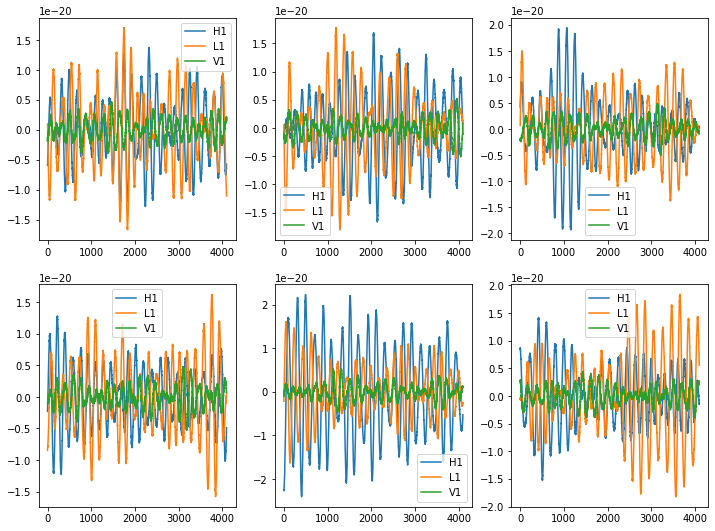

In [24]:
# checking magnitude of waves
num_files = 6
sites = ['H1',"L1","V1"]
input_file_paths = train_df['file_path'].values[:num_files]
plt.figure(figsize=(12,9))
for i,input_file_path in enumerate(input_file_paths[:num_files]):
    file_name = input_file_path.split('/')[-1].split('.npy')[0]
    waves = np.load(input_file_path)
    plt.subplot(2,3,i+1)
    for j in range(3):
        plt.plot(waves[j], label=sites[j])
    plt.legend()

In [25]:
skf = StratifiedKFold(n_splits=Config.n_fold, shuffle=True, random_state=Config.seed)
splits = skf.split(train_df, train_df["target"])
train_df['fold'] = -1
for fold, (train_index, valid_index) in enumerate(splits):
    train_df.loc[valid_index,"fold"] = fold
train_df.groupby('fold')['target'].apply(lambda s: s.value_counts(normalize=True))

fold   
0     0    0.500125
      1    0.499875
1     0    0.500125
      1    0.499875
2     0    0.500125
      1    0.499875
3     0    0.500125
      1    0.499875
4     0    0.500125
      1    0.499875
Name: target, dtype: float64

# dataset

In [26]:
transform_list = []
if Config.add_gaussian_noise:
    transform_list.append(A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5))
if Config.time_shift:
    transform_list.append(A.Shift(min_fraction=-512*1.0/4096, max_fraction=-1*1.0/4096, p=0.5,rollover=False))#<0 means shift towards left,  fraction of total sound length
if Config.pitch_shift:
    transform_list.append(A.PitchShift(min_semitones=-1, max_semitones=1, p=0.5))
if Config.time_stretch:
    transform_list.append(A.TimeStretch(min_rate=0.98, max_rate=1.02,leave_length_unchanged=True, p=0.5))
if Config.timemask:
    transform_list.append(A.TimeMask(min_band_part=0.0, max_band_part=0.01, fade=False, p=0.5))#try 0.03 next time
train_transform = A.Compose(transform_list)
test_transform = A.Compose([])

class DataRetriever(Dataset):
    def __init__(self, paths, targets, transforms=None, synthetic=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms
        #!!
        if synthetic is not None:
            self.synthetic = synthetic
            self.synthetic_keys = list(self.synthetic.keys())
        else:
            self.synthetic = None
            self.synthetic_keys = None
        self.neg_idxes = [i for i, t in enumerate(targets) if t == 0]

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        target = self.targets[index]
        path = self.paths[index]
        if target > 0 and Config.use_GW: 
            path = self.paths[random.choice(self.neg_idxes)]                
        waves = TRAIN_DATA[path] if (Config.use_ram and path in TRAIN_DATA) else np.load(path)
        
        if Config.cropping:
            waves = waves[:,1792:3840+1]

        if Config.shuffle_channels:#nn.ChannelShuffle
            if np.random.random()<0.5:
                np.random.shuffle(waves)
        if Config.shuffle01:
            if np.random.random()<0.5:
                waves[[0,1]]=waves[[1,0]]
        if Config.vflip:
            if np.random.random()<0.5:
                waves = -waves
              
        if self.transforms is not None:
            waves= self.transforms(waves,sample_rate=2048)

        x = torch.FloatTensor(waves*1e20)
        
        if target > 0 and Config.use_GW:
            #!!
            w = torch.FloatTensor((self.synthetic[random.choice(self.synthetic_keys)]))
            w = w * max(random.gauss(3.6,1),1)
            shift_place = 512+384-random.randrange(0,768)
            w = np.pad(w[:,shift_place:],[(0,0),(0,shift_place)],mode='constant')
            x += w
        target = torch.tensor(target,dtype=torch.float)#device=device,
        return (x, target)

class DataRetrieverTest(Dataset):
    def __init__(self, paths, targets, transforms=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms
        if Config.use_ram:
            array_shape = (len(self.paths),3,4096)
            self.data = np.zeros(array_shape,dtype=np.float32)
            for i,path in enumerate(self.paths):
                waves = np.load(path)
                self.data[i,:] = waves  

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index] 
        waves = TRAIN_DATA[path] if Config.use_ram else np.load(path)
        target = self.targets[index]
            
        if Config.cropping:
            waves = waves[:,1792:3840+1]
            
        if self.transforms is not None:
            waves= self.transforms(waves,sample_rate=2048)

        x = torch.FloatTensor(waves*1e20)
        target = torch.tensor(target,dtype=torch.float)#device=device, 
        #print(path) 
        return (x, target)

# Models

In [28]:
def Model_2D():
    if Config.model_name=='Model_2D':
        model = models_1d2d.Model_2D(encoder=Config.model_2D_encoder, use_raw_wave=True)
    elif Config.model_name=='Model_2D_fmin22':
        model = models_1d2d.Model_2D_fmin22(encoder=Config.model_2D_encoder, use_raw_wave=True, cut_612=Config.cut_612)
    return model    

In [29]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
model = Model_2D()#can possibly call random
get_n_params(model)

CQT kernels created, time used = 0.0148 seconds


21321089

# Util

In [30]:
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(seed=Config.seed)

def get_scheduler(optimizer, train_size):
    epoch_step = train_size/Config.batch_size
    num_warmup_steps = int(0.1 * epoch_step * Config.epochs)
    num_training_steps = int(epoch_step * Config.epochs)
    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=num_warmup_steps, 
                                                num_training_steps=num_training_steps)      
    return scheduler

def mixed_criterion(loss_fn, pred, y_a, y_b, lam):
    return lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)

def mixup_data(x, y, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and lambda"""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size, requires_grad=False).to(x.device,non_blocking=Config.non_blocking)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Number of device:', torch.cuda.device_count())

#Additional Info when using cuda
# watch nvidia-smi
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Reserved:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Number of device: 2
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Reserved:    0.0 GB


In [32]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

# LR Finder

In [33]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), f'{Config.model_output_folder}/init_params.pt')

    def range_test(self, loader, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        lrs = []
        losses = []
        best_loss = float('inf')
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        for step, batch in enumerate(loader):
            if step == num_iter:
                break
            loss = self._train_batch(batch)
            lrs.append(lr_scheduler.get_last_lr()[0])
            #update lr
            lr_scheduler.step()
            if step > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
            if loss < best_loss:
                best_loss = loss
            losses.append(loss)
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
        #reset model to initial parameters
        model.load_state_dict(torch.load(f'{Config.model_output_folder}/init_params.pt'))
        return lrs, losses

    def _train_batch(self, batch):
        self.model.train()
        self.optimizer.zero_grad()
        scaler = GradScaler()
        X = batch[0].to(self.device,non_blocking=Config.non_blocking)
        targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
        
        if Config.use_mixup:
            (X_mix, targets_a, targets_b, lam) = mixup_data(
                X, targets, Config.mixup_alpha
            )
            with autocast(enabled=False):
                outputs = self.model(X_mix).squeeze()
                loss = mixed_criterion(self.criterion, outputs, targets_a, targets_b, lam)
        else:
            with autocast(enabled=False):
                outputs = self.model(X).squeeze()
                loss = self.criterion(outputs, targets)
        #loss.backward()
        scaler.scale(loss).backward()
        
        if Config.use_tpu:
            xm.optimizer_step(self.optimizer, barrier=True)  # Note: TPU-specific code! 
        else:
            scaler.step(self.optimizer)
            scaler.update()
#             self.optimizer.step()
        return loss.item()
    
                    
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)
    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

def plot_lr_finder(lrs, losses, skip_start = 0, skip_end = 0):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

In [34]:
if Config.use_lr_finder:
    START_LR = 1e-7
    model = Model_2D()
    model.to(device,non_blocking=Config.non_blocking)
#     if torch.cuda.device_count() == 2:
#         model = nn.DataParallel(model)
    optimizer = AdamW(model.parameters(), lr=START_LR, weight_decay=Config.weight_decay, amsgrad=False)
    criterion = torch_functional.binary_cross_entropy_with_logits

    train_data_retriever = DataRetriever(train_df['file_path'], train_df["target"].values)
    train_loader = DataLoader(train_data_retriever,
                                batch_size=Config.batch_size, 
                                shuffle=True, 
                                num_workers=Config.num_workers, pin_memory=True, drop_last=True)

In [35]:
%%time
if Config.use_lr_finder:
    try:
        END_LR = 10
        NUM_ITER = 150
        lr_finder = LRFinder(model, optimizer, criterion, device)
        lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)
    except RuntimeError as e:
        del model, optimizer, criterion, train_data_retriever, train_loader, lr_finder
        gc.collect()
        torch.cuda.empty_cache() 
        print(e)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.82 µs


In [36]:
if Config.use_lr_finder:
    plot_lr_finder(lrs[:-5], losses[:-5])

# Trainer

In [37]:
def get_swa(model, optimizer):
    swa_model = AveragedModel(model)
    train_size = int(train_df.shape[0] / Config.n_fold * (Config.n_fold-1))
    epoch_step = train_size/Config.batch_size        
    swa_start_step =  epoch_step * Config.swa_start_step_epoch
    swa_scheduler = torch.optim.swa_utils.SWALR(optimizer,
                                                anneal_strategy="cos", 
                                                anneal_epochs=int(epoch_step * (Config.epochs-1)), 
                                                swa_lr=Config.swa_lr)
    return swa_model, swa_scheduler

def do_swa_scheduler(step, swa_scheduler):
    if (swa_scheduler is not None) and (step >= int(Config.swa_start_step_epoch * len(train_df) * (1 - 1/Config.n_fold))//Config.batch_size  ):
        return True
    else:
        return False

In [38]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        scheduler,
        valid_labels,
        best_valid_score,
        fold,
        swa_model=None,
        swa_scheduler=None,
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.best_valid_score = best_valid_score
        self.valid_labels = valid_labels
        self.fold = fold

        self.swa_model = swa_model
        self.swa_scheduler = swa_scheduler
        self.step = 0 # for swa

    
    def fit(self, epochs, train_loader, valid_loader, save_path): 
        train_losses = []
        valid_losses = []
        for n_epoch in range(epochs):
            start_time = time.time()
            print('Epoch: ', n_epoch)
            train_loss, train_preds = self.train_epoch(train_loader)
            valid_loss, valid_preds = self.valid_epoch(valid_loader, self.model)

            if self.swa_model is not None:
                if n_epoch >= Config.swa_start_step_epoch:
                    print(f"Epoch {n_epoch}, update swa model")
                    self.swa_model.update_parameters(self.model)


            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            if isinstance(self.scheduler, ReduceLROnPlateau):
                self.scheduler.step(valid_loss)
            valid_score = get_score(self.valid_labels, valid_preds)            

            if self.best_valid_score < valid_score:
                self.best_valid_score = valid_score
                self.save_model(n_epoch, save_path+f'best_model.pth', train_preds, valid_preds)

            print('train_loss: ',train_loss)
            print('valid_loss: ',valid_loss)
            print('valid_score: ',valid_score)
            print('best_valid_score: ',self.best_valid_score)
            print('time used: ', time.time()-start_time)

            wandb.log({f"[fold{self.fold}] epoch": n_epoch+1, 
                      f"[fold{self.fold}] avg_train_loss": train_loss, 
                      f"[fold{self.fold}] avg_val_loss": valid_loss,
                      f"[fold{self.fold}] val_score": valid_score})        
        # save swa
        if self.swa_model is not None:
            update_bn(train_loader, self.swa_model, device=self.device)
            valid_loss_swa, valid_preds_swa = self.valid_epoch(valid_loader, self.swa_model)
            valid_score_swa = get_score(self.valid_labels, valid_preds_swa)
            wandb.log({f"[fold{self.fold}] avg_val_loss_swa": valid_loss_swa, 
                      f"[fold{self.fold}] val_score_swa": valid_score_swa}) 
            print("SWA: Valid Loss {:.5f}, Valid Score {:.5f}".format(valid_loss_swa, valid_score_swa))
            # update batch normalization
            save_dict = {
                "swa_model_state_dict" : self.swa_model.state_dict(),                
                "swa_scheduler" : self.swa_scheduler.state_dict(),
                "valid_loss_swa" : valid_loss_swa,
                "valid_score_swa" : valid_score_swa,
            }
            torch.save(save_dict, save_path + f'swa_model.pth')        
            
    def train_epoch(self, train_loader):
        if Config.amp:
            scaler = GradScaler()
        self.model.train()
        losses = []
        train_loss = 0
        # preds = []
        for step, batch in enumerate(train_loader, 1):
            self.step += 1
            self.optimizer.zero_grad()
            X = batch[0].to(self.device,non_blocking=Config.non_blocking)
            targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
            
            if Config.use_mixup:
                (X_mix, targets_a, targets_b, lam) = mixup_data(
                    X, targets, Config.mixup_alpha
                )
                with autocast(enabled=False):
                    outputs = self.model(X_mix).squeeze()
                    loss = mixed_criterion(self.criterion, outputs, targets_a, targets_b, lam)
            else:
                with autocast(enabled=False):
                    outputs = self.model(X).squeeze()
                    loss = self.criterion(outputs, targets)
                    
            if Config.gradient_accumulation_steps > 1:
                loss = loss / Config.gradient_accumulation_steps
            scaler.scale(loss).backward()
          
            if (step) % Config.gradient_accumulation_steps == 0:
                scaler.step(self.optimizer)
                scaler.update()
            

            if not do_swa_scheduler(self.step, self.swa_scheduler):
                self.scheduler.step()
                lr2 = self.scheduler.get_last_lr()[0]
            else:
                self.swa_scheduler.step()
                lr2 = self.swa_scheduler.get_last_lr()[0]


            loss2 = loss.detach()

            wandb.log({f"[fold{self.fold}] loss": loss2,
                       f"[fold{self.fold}] lr": lr2})            

            losses.append(loss2)
            train_loss += loss2

            if (step) % Config.print_num_steps == 0:
                train_loss = train_loss.item() #synch once per print_num_steps instead of once per batch
                print(f'[{step}/{len(train_loader)}] ', 
                      f'avg loss: ',train_loss/step,
                      f'inst loss: ', loss2.item())
                        
        return train_loss / step, None

    def valid_epoch(self, valid_loader, model):
        model.eval()      
        valid_loss = []
        preds = []
        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch[0].to(self.device,non_blocking=Config.non_blocking)
                targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
                outputs = model(X).squeeze()
                loss = self.criterion(outputs, targets)
                if Config.gradient_accumulation_steps > 1:
                    loss = loss / Config.gradient_accumulation_steps
                valid_loss.append(loss.detach().item())
                preds.append(outputs.sigmoid().to('cpu').numpy())
        predictions = np.concatenate(preds)
        return np.mean(valid_loss), predictions

    def save_model(self, n_epoch, save_path, train_preds, valid_preds):
        print("Save Model")
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
                'scheduler': self.scheduler.state_dict(),
                'train_preds': train_preds,
                'valid_preds': valid_preds,
            },
            save_path,
        )

# Training loop

In [39]:
seed_torch(seed=Config.seed)

In [40]:
def generate_PL(fold, train_df,test_df):
    pseudo_label_df = pd.read_csv(Config.pseudo_label_folder + f"test_Fold_{fold}.csv")     
    pseudo_label_df['file_path'] = pseudo_label_df['id'].apply(lambda x :id_2_path_wave(x,False))
    pseudo_label_df["target"] = pseudo_label_df[f'preds_Fold_{fold}']
    test_df_2 = pseudo_label_df.copy()
    test_df_2['fold'] = -1
    PL_train_df = pd.concat([train_df, test_df_2]).reset_index(drop=True)
    PL_train_df.reset_index(inplace=True, drop=True)
    return PL_train_df

In [41]:
def training_loop(train_df, use_checkpoint=Config.use_checkpoint):
    kf = StratifiedKFold(n_splits=Config.n_fold, shuffle=True, random_state=Config.seed)
    avg_best_valid_score = 0
    folds_val_score = []
    original_train_df = train_df.copy()#for PL
    for fold in range(Config.n_fold): 
        if Config.use_PL:
            PL_train_df = generate_PL(fold,original_train_df.copy(),test_df)   
            train_df = PL_train_df
        train_index, valid_index = train_df.query(f"fold!={fold}").index, train_df.query(f"fold=={fold}").index #fold means fold_valid 
        print('Fold: ', fold)
        if fold not in Config.train_folds:
            print("skip")
            continue
        train_X, valid_X = train_df.loc[train_index], train_df.loc[valid_index]
        valid_labels = train_df.loc[valid_index,Config.target_col].values
        oof = pd.DataFrame()
        oof['id'] = train_df.loc[valid_index,'id']
        oof['id'] = valid_X['id'].values.copy()
        oof = oof.reset_index()
        oof['preds'] = valid_labels
        oof.to_csv(f'{Config.model_output_folder}/Fold_{fold}_oof_pred.csv')

        print('training data samples, val data samples: ', len(train_X) ,len(valid_X))
        if Config.use_GW:
            #!!
            train_data_retriever = DataRetriever(train_X["file_path"].values, train_X["target"].values, transforms=train_transform,synthetic=SIGNAL_DICT)
        else:
            train_data_retriever = DataRetriever(train_X["file_path"].values, train_X["target"].values, transforms=train_transform)

        valid_data_retriever = DataRetrieverTest(valid_X["file_path"].values, valid_X["target"].values, transforms=test_transform)       
        
        train_loader = DataLoader(train_data_retriever,
                                  batch_size=Config.batch_size, 
                                  shuffle=True, 
                                  num_workers=Config.num_workers, pin_memory=True, drop_last=False)
        valid_loader = DataLoader(valid_data_retriever, 
                                  batch_size=Config.batch_size * 2, 
                                  shuffle=False, 
                                  num_workers=Config.num_workers, pin_memory=True, drop_last=False)

        model = Model_2D()
        model.to(device,non_blocking=Config.non_blocking)
        #if torch.cuda.device_count() == 2:
        #    model = nn.DataParallel(model)
        optimizer = AdamW(model.parameters(), lr=Config.lr,eps=1e-08, weight_decay=Config.weight_decay, amsgrad=False) #eps to avoid NaN/Inf in training loss
        scheduler = get_scheduler(optimizer, len(train_X))
        swa_model, swa_scheduler = None, None
        best_valid_score = -np.inf
        if use_checkpoint:
            #!!
            model_folder = Config.model_output_folder if Config.prev_model_folder is None else Config.prev_model_folder
            print(f"Load Checkpoint from folder: {model_folder}")
            checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            best_valid_score = float(checkpoint['best_valid_score'])
        if Config.use_swa:
            print("Use SWA")
            swa_model, swa_scheduler = get_swa(model, optimizer)
        scheduler = get_scheduler(optimizer, len(train_X))
        
        
        criterion = torch_functional.binary_cross_entropy_with_logits
        

        trainer = Trainer(
            model, 
            device, 
            optimizer, 
            criterion,
            scheduler,
            valid_labels,
            best_valid_score,
            fold,
            swa_model,
            swa_scheduler
        )

        history = trainer.fit(
            epochs=Config.epochs, 
            train_loader=train_loader, 
            valid_loader=valid_loader,
            save_path=f'{Config.model_output_folder}/Fold_{fold}_',
        )
        folds_val_score.append(trainer.best_valid_score)
    wandb.finish()
    print('folds score:', folds_val_score)
    print("Avg: {:.5f}".format(np.mean(folds_val_score)))
    print("Std: {:.5f}".format(np.std(folds_val_score)))

# Weight & Bias Initialization

In [42]:
wandb.login(key="")

wandb: Currently logged in as: vincentwang25 (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/.netrc


True

# Train

## Pretraining

In [43]:
# %%time
# Config.epochs = 2
# Config.use_GW = True
# Config.use_PL = False
# Config.use_checkpoint = False
# Config.use_swa = False
# run = wandb.init(project="G2Net", name=Config.model_version + "_pretrain" , config=class2dict(Config), group=Config.model_name, job_type=Config.model_version)
# try:
# #     %lprun -f DataRetriever.__getitem__ -f Trainer.train_epoch -f Trainer.fit -f Trainer.valid_epoch training_loop() 
#     training_loop(train_df.copy(),Config.use_checkpoint)
# except (ValueError, RuntimeError, KeyboardInterrupt) as e:
#     wandb.finish()    
#     gc.collect()
#     torch.cuda.empty_cache()   
#     print(e)# saving oof predictions

## Training

In [44]:
%%time

Config.epochs = 4
Config.cut_612 = False

Config.use_PL = False
Config.use_checkpoint = False
Config.use_GW = False
Config.use_swa = False

run_error = False
run = wandb.init(project="G2Net", name=Config.model_version , config=class2dict(Config), group=Config.model_name, job_type=Config.model_version)
try:
#     %lprun -f DataRetriever.__getitem__ -f Trainer.train_epoch -f Trainer.fit -f Trainer.valid_epoch training_loop() 
    training_loop(train_df.copy(),Config.use_checkpoint)
except (ValueError, RuntimeError, KeyboardInterrupt) as e:
    wandb.finish()
    run_error=True
    gc.collect()
    torch.cuda.empty_cache()   
    print(e)# saving oof predictions

Fold:  0
training data samples, val data samples:  448000 112000
CQT kernels created, time used = 0.0148 seconds
Epoch:  0


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[350/1750]  avg loss:  0.4790022495814732 inst loss:  0.4300946891307831
[700/1750]  avg loss:  0.4532602800641741 inst loss:  0.48799753189086914
[1050/1750]  avg loss:  0.44401721772693453 inst loss:  0.3786649703979492
[1400/1750]  avg loss:  0.43736332484654017 inst loss:  0.41919827461242676
[1750/1750]  avg loss:  0.4328866489955357 inst loss:  0.4228212237358093
Save Model
train_loss:  0.4328866489955357
valid_loss:  0.418924433727787
valid_score:  0.8709513729931342
best_valid_score:  0.8709513729931342
time used:  739.6181964874268
Epoch:  1
[350/1750]  avg loss:  0.4108201817103795 inst loss:  0.3891768753528595
[700/1750]  avg loss:  0.41144784109933036 inst loss:  0.39694613218307495
[1050/1750]  avg loss:  0.4115652320498512 inst loss:  0.4135272204875946
[1400/1750]  avg loss:  0.41085030691964286 inst loss:  0.39553719758987427
[1750/1750]  avg loss:  0.40992239815848214 inst loss:  0.33664625883102417
Save Model
train_loss:  0.40992239815848214
valid_loss:  0.4078415683

[fold0] avg_train_loss,0.39115
[fold0] avg_val_loss,0.39935
[fold0] epoch,4
[fold0] loss,0.3794
[fold0] lr,0.0
[fold0] val_score,0.87663


[fold0] avg_train_loss,█▄▃▁
[fold0] avg_val_loss,█▄▁▁
[fold0] epoch,▁▃▆█
[fold0] loss,█▇▆▆▇▆▅▃▄▃▆▅▄▅▃▄▄▆▃▄▄▃▅▅▁▄▄▆▆▄▅▆▇▄▄▆▄▅▃▃
[fold0] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
[fold0] val_score,▁▃▇█


folds score: [0.8766257921934487]
Avg: 0.87663
Std: 0.00000
CPU times: user 56min 18s, sys: 1min 17s, total: 57min 36s
Wall time: 56min 4s


In [46]:
%%time

Config.epochs = 4
Config.cut_612 = True

Config.use_PL = False
Config.use_checkpoint = False
Config.use_GW = False
Config.use_swa = False

run_error = False
run = wandb.init(project="G2Net", name=Config.model_version+"_cut612" , config=class2dict(Config), group=Config.model_name, job_type=Config.model_version)
try:
#     %lprun -f DataRetriever.__getitem__ -f Trainer.train_epoch -f Trainer.fit -f Trainer.valid_epoch training_loop() 
    training_loop(train_df.copy(),Config.use_checkpoint)
except (ValueError, RuntimeError, KeyboardInterrupt) as e:
    wandb.finish()
    run_error=True
    gc.collect()
    torch.cuda.empty_cache()   
    print(e)# saving oof predictions

Fold:  0
training data samples, val data samples:  448000 112000
CQT kernels created, time used = 0.0156 seconds
Cut 612 frequency range
Epoch:  0
[350/1750]  avg loss:  0.4735546875 inst loss:  0.41856780648231506
[700/1750]  avg loss:  0.4520217023577009 inst loss:  0.4355897307395935
[1050/1750]  avg loss:  0.4427425420851935 inst loss:  0.38543298840522766
[1400/1750]  avg loss:  0.4367357962472098 inst loss:  0.4505072832107544
[1750/1750]  avg loss:  0.4325429338727679 inst loss:  0.3898415267467499
Save Model
train_loss:  0.4325429338727679
valid_loss:  0.4128577506433339
valid_score:  0.8707776555077871
best_valid_score:  0.8707776555077871
time used:  1238.8589725494385
Epoch:  1
[350/1750]  avg loss:  0.4128870936802455 inst loss:  0.3921718895435333
[700/1750]  avg loss:  0.41140638078962055 inst loss:  0.45730307698249817
[1050/1750]  avg loss:  0.4122132800874256 inst loss:  0.38512957096099854
[1400/1750]  avg loss:  0.41132193429129466 inst loss:  0.4302365779876709
[175

[fold0] avg_train_loss,0.39194
[fold0] avg_val_loss,0.39871
[fold0] epoch,4
[fold0] loss,0.37996
[fold0] lr,0.0
[fold0] val_score,0.87699


[fold0] avg_train_loss,█▄▃▁
[fold0] avg_val_loss,█▅▂▁
[fold0] epoch,▁▃▆█
[fold0] loss,█▇▅▅▅▃▅▃▆▆▄▃▅▃▇▅▆▄▅▄▇▆▃▄▆▄▆▃█▄▅▃▆▅▃▄▅▁▄▃
[fold0] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
[fold0] val_score,▁▄▇█


folds score: [0.8769906263999243]
Avg: 0.87699
Std: 0.00000
CPU times: user 1h 14min 6s, sys: 1min 21s, total: 1h 15min 28s
Wall time: 1h 13min 55s


# add TTA

In [30]:
def get_pred(loader,model):
    preds = []
    for step, batch in enumerate(loader, 1):
        if step % Config.print_num_steps == 0:
            print("step {}/{}".format(step, len(loader)))
        with torch.no_grad():
            X = batch[0].to(device,non_blocking=Config.non_blocking)
            outputs = model(X).squeeze()
            preds.append(outputs.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

def get_tta_pred(df,model,**transforms):
    data_retriever = TTA(df['file_path'].values, df['target'].values, **transforms)
    loader = DataLoader(data_retriever, 
                            batch_size=Config.batch_size * 2, 
                            shuffle=False, 
                            num_workers=Config.num_workers, pin_memory=True, drop_last=False)
    return get_pred(loader,model)

In [43]:
def get_tta_df(df, model):
    #df["tta_vflip"] = get_tta_pred(df,model,use_vflip=True)
    # df["tta_shift"] = get_tta_pred(df,model,time_shift=True)
    # df["tta_vflip_shift"] = get_tta_pred(df,model,use_vflip=True,time_shift=True)
    df["tta_shuffle01"] = get_tta_pred(df,model,shuffle01=True)
    #df["tta_vflip_shuffle01"] = get_tta_pred(df,model,use_vflip=True,shuffle01=True)
    # df["tta_shift_shuffle01"] = get_tta_pred(df,model,time_shift=True,shuffle01=True)
    # df["tta_vflip_shift_shuffle01"] = get_tta_pred(df,model,use_vflip=True,time_shift=True,shuffle01=True)
    return df

In [34]:
model = Model_2D()
oof_all = pd.DataFrame()
for fold in tqdm(Config.train_folds):
    oof = train_df.query(f"fold=={fold}").copy()
    oof['preds'] = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')['valid_preds']
    oof['file_path'] = train_df['id'].apply(lambda x :id_2_path_wave(x))
    # display(oof)    
    if Config.use_swa:
        swa_model = AveragedModel(model)
        checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_swa_model.pth')
        model = swa_model
        model.load_state_dict(checkpoint['model_swa_state_dict'])
    else:
        checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        
    model.to(device=device,non_blocking=Config.non_blocking)
    #if torch.cuda.device_count() == 2:
    #    model = nn.DataParallel(model)
    model.eval()
    oof = get_tta_df(oof, model)
    oof.to_csv(Config.model_output_folder + f"/oof_Fold_{fold}.csv", index=False)
    oof_all = pd.concat([oof_all,oof])

CQT kernels created, time used = 0.0168 seconds


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [36]:
oof_all.isna().sum()

id               0
target           0
file_path        0
fold             0
preds            0
tta_shuffle01    0
avg              0
dtype: int64

In [35]:
print("Original:",roc_auc_score(oof_all['target'], oof_all['preds']))

for col in oof.columns:
    if "tta" in col:
        print(col,roc_auc_score(oof_all['target'], oof_all[col]))

avg_cols = [col for col in oof_all.columns if "tta" in col or "preds" in col]
oof_all['avg']=oof_all[avg_cols].mean(axis=1)
print("preds_tta_avg:",roc_auc_score(oof_all['target'], oof_all['avg']))
CV_SCORE = roc_auc_score(oof_all['target'], oof_all['avg'])
oof_all.to_csv(Config.model_output_folder + "/oof_all.csv", index=False)
oof_all[['id','fold','avg']].rename(columns={'id':'id','fold':'fold','avg':'prediction'}).to_csv(Config.model_output_folder + "/oof_final.csv", index=False)

Original: 0.8774815909778035
tta_shuffle01 0.8775112540089942
preds_tta_avg: 0.8775880040265462


In [37]:
oof_all.groupby("fold").apply(lambda df: roc_auc_score(df['target'],df['avg']))

fold
0    0.878338
1    0.876807
2    0.876766
3    0.878762
4    0.877551
dtype: float64

In [48]:
CV_SCORE = oof_all.groupby("fold").apply(lambda df: roc_auc_score(df['target'],df['avg'])).mean()
CV_SCORE

0.8776446265683504

<AxesSubplot:>

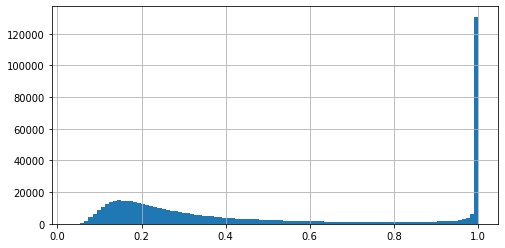

In [39]:
oof_all['avg'].hist(bins=100, figsize=(8,4))

In [44]:
%%time 
test_df['target'] = 0  
model = Model_2D()
test_avg = test_df[['id', 'target']].copy()
test_avg_rank = test_df[['id', 'target']].copy()
count = 0
for fold in tqdm(Config.train_folds):
    test_df2 = test_df.copy()
    if Config.use_swa:
        swa_model = AveragedModel(model)
        checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_swa_model.pth')
        model = swa_model
        model.load_state_dict(checkpoint['model_swa_state_dict'])
    else:
        checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])

    model.to(device=device,non_blocking=Config.non_blocking)
    #if torch.cuda.device_count() == 2:
    #    model = nn.DataParallel(model)
    model.eval()
    test_df2['preds'+f'_Fold_{fold}'] = get_tta_pred(test_df2,model)
    test_df2 = get_tta_df(test_df2, model)
    test_df2.to_csv(Config.model_output_folder + f"/test_Fold_{fold}.csv", index=False)
    for col in test_df2.columns:
        if "tta" in col or 'preds' in col: 
            count+=1
            test_avg['target'] += test_df2[col]
            test_avg_rank['target'] += test_df2[col].rank(pct=True)
test_avg['target'] /= count
test_avg_rank['target'] /= count

CQT kernels created, time used = 0.0236 seconds


step 350/442
step 350/442
step 350/442
step 350/442
step 350/442

CPU times: user 10min 49s, sys: 37.5 s, total: 11min 26s
Wall time: 10min 47s


count    226000.000000
mean          0.476840
std           0.345621
min           0.044251
25%           0.183877
50%           0.317945
75%           0.933208
max           1.000000
Name: target, dtype: float64

<AxesSubplot:>

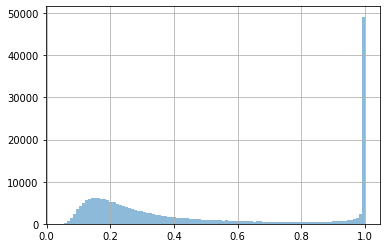

In [45]:
display(test_avg["target"].describe())
test_avg['target'].hist(bins=100, alpha=.5)

In [46]:
assert test_avg['target'].isna().sum() == 0

In [47]:
test_avg[['id', 'target']]

,id,target
0,00005bced6,0.999989
1,0000806717,0.974939
2,0000ef4fe1,0.241514
3,00020de251,0.838608
4,00024887b5,0.149705
...,...,...
225995,ffff4125f1,0.292236
225996,ffff9d32a6,0.276294
225997,ffff9f4c1f,0.228145
225998,ffffa19693,0.999904


In [49]:
test_avg[['id', 'target']].to_csv(Config.model_output_folder + f"/submission_CV{CV_SCORE * 1e5:.0f}.csv", index=False)
test_avg_rank[['id', 'target']].to_csv(Config.model_output_folder + f"/submission_CV{CV_SCORE * 1e5:.0f}_rank.csv", index=False)
print(Config.model_output_folder + f"/submission_CV{CV_SCORE * 1e5:.0f}.csv")

./output_model/resnet34-sGW2ep-PL-sc01-5ep//submission_CV87764.csv


In [ ]:
# test_avg[['id', 'target']].to_csv("./submission.csv", index=False)
# !mkdir -p ~/.kaggle/ && cp $Config.kaggle_json_path ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
#!kaggle competitions submit -c g2net-gravitational-wave-detection -f ./submission.csv -m $Config.model_version

In [ ]:
# test_avg

# Pause

In [ ]:
%%javascript
import Ipython
IPython.notebook.save_notebook()

In [ ]:
from time import sleep
sleep(120)

In [ ]:
from jarviscloud import jarviscloud
jarviscloud.pause()